In [91]:
import heapq
import random
import numpy as np

In [148]:
# Initialisation des variables globales
DateSimu = 0.0  # Temps simulé
Echeancier = []  # Liste des événements sous forme de tas (heap)

# Variables du système

NbBus = 0       # Nombre total de bus arrivés
NbBusRep = 0    # Nombre de bus nécessitant une réparation
QC = 0          # Nombre de bus dans la file de contrôle
QR = 0          # Nombre de bus dans la file de réparation`
BC = 0          # Statut du centre de contrôle (0: libre, 1: occupé)
BR = 0          # Nombre de postes de réparation occupés (max 2)
  # Variables pour les statistiques
AireQC = 0    # Aire sous la courbe de QC
AireQR = 0.0    # Aire sous la courbe de QR
AireBR = 0.0    # Aire sous la courbe de BR

DurCtrlMin = 15 # La duree de controle Minimal (en minutes)
DurCtrlMax = 65 # La duree de controle Maximal (en minutes)
DurRepaMin = 2.8*60.0 # La duree de reparation Minimal (en minutes)
DurRepaMax = 5.5*60.0 # La duree de reparation Maximal (en minutes)

BusControl=0

BusArrivalTimes = []
WaitingTimes = []




In [93]:
# t : tuple (Evt, Date)
def insertIntoEcheanchier(t) :
  global Echeancier

  Echeancier.append(t)
  Echeancier.sort(key=lambda x: x[1])

In [149]:
# Definition des evenements
def ArriveeBus(date):
  global NbBus

  # Planifier la prochaine arriee de bus
  inter_arrival = np.random.exponential(3/4)*60.0 # Moyenne de 2 heures puis convertir en minutes
  insertIntoEcheanchier((0, date + inter_arrival ))

  # Incrementer le nombre de bus
  NbBus +=1
  #Inserer l'evenement ArriveeFileC
  insertIntoEcheanchier((1, date))

#Arrive file de controle
def ArriveeFileC(date):
  global QC, BC, BusArrivalTimes
  QC +=1
  BusArrivalTimes.append(date)
  if BC == 0:
    insertIntoEcheanchier((2, date))

def AccessControle(date):
  global QC, BC
  QC -= 1
  BC = 1 # Le centre de controle est maintenant occupe
  #Duree du controle (uniforme entre 15 min et 1h05)
  duree_controle = random.uniform(DurCtrlMin, DurCtrlMax)
  insertIntoEcheanchier((3, date + duree_controle))

# Je vais definir une fonction AccessControle pour la question 5 qui verifie que le nombre de bus
# ayant accede au controle est egale a m et declanche ensuite l'evenement fin simulation

def AccessControleQuestion5(date):
  global QC, BC, NbBus, BusArrivalTimes, WaitingTimes, m, BusControl
  BusControl += 1
  if BusControl == m:
    QC -= 1
    BC = 1 # Le centre de controle est maintenant occupe
    insertIntoEcheanchier((8, date))
  else:
     QC -= 1
     BC = 1 # Le centre de controle est maintenant occupe
     arrival_time = BusArrivalTimes.pop(0)
     waiting_time = date - arrival_time
     WaitingTimes.append(waiting_time)
     duree_controle = random.uniform(DurCtrlMin, DurCtrlMax)
     insertIntoEcheanchier((3, date + duree_controle))


def DepartControle(date):
  global QC, BC, QR


  BC = 0 # Le centre de controle est maintenant libre
  if QC > 0:
    insertIntoEcheanchier((2, date))
  # Probabilite de 30% de necessiter une reparation
  if random.random() < 0.3:
    insertIntoEcheanchier((4,date))

# Arrive file de reparation
def ArriveeFileR(date):
  global QR, BC, BR, NbBusRep
  QR += 1
  NbBusRep += 1
  if BR < 2:
    insertIntoEcheanchier((5,date))

def AccesReparation(date):
    global QR, BR
    QR -= 1
    BR += 1  # Un poste de réparation est maintenant occupé
    # Durée de la réparation (uniforme entre 2.8 et 5.5 heures)
    duree_reparation = random.uniform(DurRepaMin, DurRepaMax)
    insertIntoEcheanchier((6,date))

def DebutSimulation(date):
  global NbBus, NbBusRep, QC, QR, BC, BR, AireQC, AireQR, AireBR


  # Initialisation de variables systeme

  NbBus = 0       # Nombre total de bus arrivés
  NbBusRep = 0    # Nombre de bus nécessitant une réparation
  QC = 0          # Nombre de bus dans la file de contrôle
  QR = 0          # Nombre de bus dans la file de réparation`
  BC = 0          # Statut du centre de contrôle (0: libre, 1: occupé)
  BR = 0          # Nombre de postes de réparation occupés (max 2)
  
  # Variables pour les statistiques
  AireQC = 0.0    # Aire sous la courbe de QC
  AireQR = 0.0    # Aire sous la courbe de QR
  AireBR = 0.0    # Aire sous la courbe de BR
  # Planifier la premiere arrivee de bus
  Inter_arrival = random.expovariate(1/2) *60 # Moyenne de 2 heures
  insertIntoEcheanchier((0, DateSimu + Inter_arrival))
  # Planifier la fin de la simulation
  insertIntoEcheanchier((8, 40.0*60)) # je dois enlever ca

def DebutSimulationQ5(date, endnumber):
  global NbBus, NbBusRep, QC, QR, BC, BR, AireQC, AireQR, AireBR,m, BusControl


  # Initialisation de variables systeme
  m= endnumber
  NbBus = 0       # Nombre total de bus arrivés
  NbBusRep = 0    # Nombre de bus nécessitant une réparation
  QC = 0          # Nombre de bus dans la file de contrôle
  QR = 0          # Nombre de bus dans la file de réparation`
  BC = 0          # Statut du centre de contrôle (0: libre, 1: occupé)
  BR = 0          # Nombre de postes de réparation occupés (max 2)
  BusControl = 0
  # Variables pour les statistiques
  AireQC = 0.0    # Aire sous la courbe de QC
  AireQR = 0.0    # Aire sous la courbe de QR
  AireBR = 0.0    # Aire sous la courbe de BR
  # Planifier la premiere arrivee de bus
  Inter_arrival = random.expovariate(1/2) *60 # Moyenne de 2 heures
  insertIntoEcheanchier((0, DateSimu + Inter_arrival))
  # Planifier la fin de la simulation
  

def FinSimulation(date):
  global Echeancier, NbBus, NbBusRep, AireQC, AireQR, AireBR, TattenteMoyenneAvantControle, TattenteMoyenneAvantReparation, TauxUtilisationCentreReparation, WaitingTimes

  Echeancier = []
  TattenteMoyenneAvantControle = AireQC/NbBus
  if NbBusRep > 0:
    TattenteMoyenneAvantReparation = AireQR/NbBusRep
  else :
    TattenteMoyenneAvantReparation = 0
  TauxUtilisationCentreReparation = AireBR/(2*160.0*60)

  print(f"Temps d'attente moyen avant controle = {TattenteMoyenneAvantControle/60.0}\nTemps d'attente moyen avant reparation = {TattenteMoyenneAvantReparation/60.0}\nTaux d'utilisation du centre de reparation = {TauxUtilisationCentreReparation}\n NbBus = {NbBus}" )
  print(f"AireQc = {AireQC}\t AireQR = {AireQR}\t AireBR = {AireBR}")
  print(f"WaitingTimes = {WaitingTimes}")
  print(f"Mean waiting time = {np.mean(WaitingTimes)}")

def FinSimulationQ5(date):
  global Echeancier, NbBus, NbBusRep, AireQC, AireQR, AireBR, TattenteMoyenneAvantControle, TattenteMoyenneAvantReparation, TauxUtilisationCentreReparation
  Echeancier = []
  TattenteMoyenneAvantControle = AireQC/NbBus
  if NbBusRep > 0:
    TattenteMoyenneAvantReparation = AireQR/NbBusRep
  else :
    TattenteMoyenneAvantReparation = 0
  TauxUtilisationCentreReparation = AireBR/(2*date)

  print(f"Temps d'attente moyen avant controle = {TattenteMoyenneAvantControle/60.0}\nTemps d'attente moyen avant reparation = {TattenteMoyenneAvantReparation/60.0}\nTaux d'utilisation du centre de reparation = {TauxUtilisationCentreReparation}\n NbBus = {NbBus}" )
  print(f"AireQc = {AireQC}\t AireQR = {AireQR}\t AireBR = {AireBR}")
  
def AccessReparation(date) :
  global QR, BR
  QR-=1
  BR+=1
  duree_reparation = random.uniform(DurRepaMin, DurRepaMax)
  insertIntoEcheanchier((6,DateSimu + duree_reparation))

def DepartReparation(date) :
  global QR, BR
  BR-=1
  if QR > 0 :
    insertIntoEcheanchier((5, DateSimu))





In [95]:
liste = [(1, 2), (2, 3), (0, 3)]
liste.sort(key=lambda x: x[1])
print(liste)

[(1, 2), (2, 3), (0, 3)]


# **Simulateur**

In [96]:
def MiseAJourDesAires(D1,D2) :
  global AireQC, AireQR, AireBR  # Declare variables as global
  AireQC = AireQC + (D2-D1)*QC
  AireQR = AireQR + (D2-D1)*QR
  AireBR = AireBR + (D2-D1)*BR

In [97]:
# ArrivéeBus->0
# ArriveeFileC->1
# AccesControle->2
# DepartControle->3
# ArriveeFileR->4
# AccesReparation->5
# DepartReparation->6
# DebutSimulation->7
# FinSimulation->8
# MiseAJourDesAires->9

In [98]:
def Simulateur() :
  global DateSimu, Echeancier
  DateSimu = 0.0
  Echeancier = []
  insertIntoEcheanchier((7, DateSimu))
  while Echeancier != [] :

    Evt, Date = Echeancier.pop(0)
    MiseAJourDesAires(DateSimu, Date)
    DateSimu = Date
    match Evt :
      case 0 :
        ArriveeBus(DateSimu)
      case 1 :
        ArriveeFileC(DateSimu)
      case 2 :
        AccessControle(DateSimu)
      case 3 :
        DepartControle(DateSimu)
      case 4 :
        ArriveeFileR(DateSimu)
      case 5 :
        AccessReparation(DateSimu)
      case 6 :
        DepartReparation(DateSimu)
      case 7 :
        DebutSimulation(DateSimu)
      case 8 :
        FinSimulation(DateSimu)



In [152]:
# Ce simulateur poura etre utiliser dans la question 5
def SimulateurQuestion5(m) :
  global DateSimu, Echeancier, NbBus
  DateSimu = 0.0
  Echeancier = []
  insertIntoEcheanchier((7, DateSimu))
  while Echeancier != [] :

    Evt, Date = Echeancier.pop(0)
    # print(Evt, Date)
    MiseAJourDesAires(DateSimu, Date)
    DateSimu = Date
    match Evt :
      case 0 :
        ArriveeBus(DateSimu)
      case 1 :
        ArriveeFileC(DateSimu)
      case 2 :
        AccessControleQuestion5(DateSimu)
      case 3 :
        DepartControle(DateSimu)
      case 4 :
        ArriveeFileR(DateSimu)
      case 5 :
        AccessReparation(DateSimu)
      case 6 :
        DepartReparation(DateSimu)
      case 7 :
        DebutSimulationQ5(DateSimu,m)
      case 8 :
        FinSimulationQ5(DateSimu)
  print(Echeancier)


In [110]:
Simulateur()

Temps d'attente moyen avant controle = 0.6956730993410302
Temps d'attente moyen avant reparation = 0.9294940741042911
Taux d'utilisation du centre de reparation = 0.2115393845247602
 NbBus = 54
AireQc = 2253.9808418649377	 AireQR = 1059.6232444788918	 AireBR = 4061.5561828753957
WaitingTimes = [-38.05136869891178, -92.82064669124205, -218.56249287298016, -170.30615627305588, -83.4854430457354, -4.914853594444935, 55.70192346925427, 109.3440628241238, 144.23762328810926, 289.39875503837163, 338.98110124069984, 402.37480572029733, 415.30979368399255, 346.77233137405494, 358.40132608351246, 323.2883575799891, 382.29946242566825, 395.5056676274928, 432.7659290834508, 446.723938938837, 470.5666151577012, 418.8480934610135, 410.29830279048883, 462.71893680857397, 351.1124269157415, 358.68084731331646, 424.56436070327845, 409.4474791211462, 451.9216773534922, 441.37199302636463, 405.72891005784777, 310.2950783855001, 350.22013606572636, 400.34923709079044, 366.4962132444339, 371.7033875913641

In [183]:
SimulateurQuestion5(1000)

Temps d'attente moyen avant controle = 2.1957735861033734
Temps d'attente moyen avant reparation = 2.514172973634315
Taux d'utilisation du centre de reparation = 0.8184234799263213
 NbBus = 1006
AireQc = 132536.89365719963	 AireQR = 46311.06617434407	 AireBR = 75757.3495008293
[]


[0.71, 0.76, 1.36, 2.49, 2.63, 2.97, 3.03, 4.19, 6.91, 7.29, 7.52, 9.26, 9.92, 9.97, 10.35, 11.86, 11.92, 12.09, 12.84, 13.08, 13.21, 15.71, 16.12, 16.72, 17.76, 19.7, 19.85, 20.73, 21.03, 21.24, 23.37, 25.01, 25.74, 25.78, 26.01, 27.01, 27.49, 27.81, 27.99, 28.26, 28.53, 30.29, 31.03, 32.65, 34.29, 34.33, 34.89, 35.48, 35.54, 35.87, 36.0, 36.26, 36.9, 37.16, 37.45, 39.07, 39.61, 41.0, 41.51, 42.31, 42.74, 43.0, 46.76, 47.69, 47.69, 48.43, 49.18, 49.92, 50.35, 50.88, 52.23, 52.56, 53.16, 53.95, 54.11, 55.56, 55.91, 57.13, 57.13, 57.28, 59.13, 59.48, 59.7, 59.92, 60.19, 60.4, 60.41, 60.72, 61.83, 61.99, 62.75, 62.99, 63.39, 64.21, 64.46, 65.48, 65.99, 66.49, 67.03, 67.2, 67.32, 67.38, 67.52, 68.24, 70.24, 70.46, 71.31, 71.38, 71.6, 71.67, 72.0, 72.03, 72.15, 72.2, 72.97, 73.48, 73.56, 75.23, 75.64, 76.03, 77.47, 78.6, 78.89, 80.83, 80.86, 80.91, 81.16, 82.11, 82.37, 82.73, 82.76, 83.57, 84.76, 84.89, 85.45, 87.85, 88.23, 89.33, 89.45, 89.91, 90.0, 90.26, 90.51, 91.72, 91.86, 93.33, 93.8

[0.05 0.6  1.13 0.14 0.34 0.06 1.16 2.72 0.38 0.23 1.74 0.66 0.05 0.38
 1.51 0.06 0.17 0.75 0.24 0.13 2.5  0.41 0.6  1.04 1.94 0.15 0.88 0.3
 0.21 2.13 1.64 0.73 0.04 0.23 1.   0.48 0.32 0.18 0.27 0.27 1.76 0.74
 1.62 1.64 0.04 0.56 0.59 0.06 0.33 0.13 0.26 0.64 0.26 0.29 1.62 0.54
 1.39 0.51 0.8  0.43 0.26 3.76 0.93 0.   0.74 0.75 0.74 0.43 0.53 1.35
 0.33 0.6  0.79 0.16 1.45 0.35 1.22 0.   0.15 1.85 0.35 0.22 0.22 0.27
 0.21 0.01 0.31 1.11 0.16 0.76 0.24 0.4  0.82 0.25 1.02 0.51 0.5  0.54
 0.17 0.12 0.06 0.14 0.72 2.   0.22 0.85 0.07 0.22 0.07 0.33 0.03 0.12
 0.05 0.77 0.51 0.08 1.67 0.41 0.39 1.44 1.13 0.29 1.94 0.03 0.05 0.25
 0.95 0.26 0.36 0.03 0.81 1.19 0.13 0.56 2.4  0.38 1.1  0.12 0.46 0.09
 0.26 0.25 1.21 0.14 1.47 0.48 0.93 0.94 0.41 0.96 0.46 0.38 0.91 1.09
 0.12 0.26 0.95 0.4  1.3  0.22 0.02 0.31 1.22 1.48 1.   0.37 0.49 0.43
 0.73 0.05 1.89 1.63 0.27 0.61 1.36 1.41 1.97 0.74 1.31 3.04 0.5  1.11
 0.   1.   0.42 0.53 0.63 0.09 1.94 0.59 1.5  0.38 0.45 0.13 0.56 0.19
 0.24 0

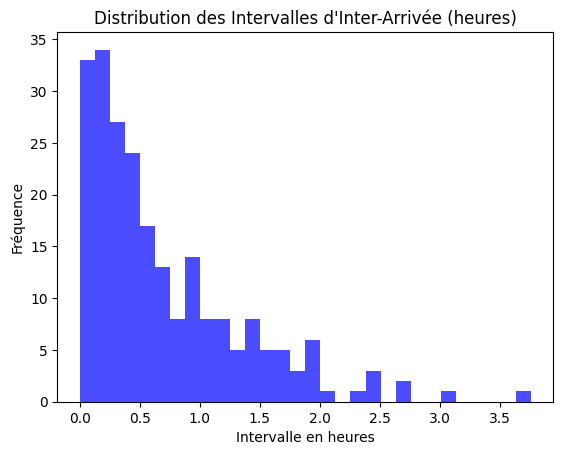

Test du χ² pour la loi exponentielle: 0.665063392197172
Test du χ² pour la loi normale: 0.0
Test du χ² pour la loi gamma: 0.39628565867645776
Estimation de lambda : 1.4294710327455922


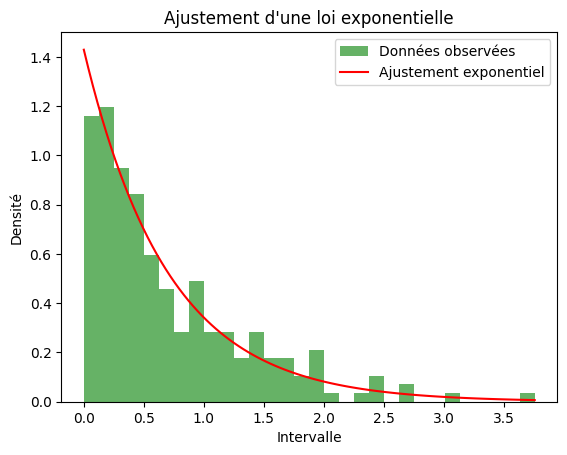

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2, expon, norm, gamma


####################loi d'inter-arrivée#####################################
# Charge les données du fichier et extraire les heures d'arrivée
arrivals = []
with open("DonneesControle.txt", "r") as file:
    for line in file:
        data = line.strip().split()  # Sépare les valeurs par espace
        arrivals.append(float(data[0]))  # Récupère uniquement l'heure d'arrivée (première valeur)

# Convertir les heures d'arrivée en temps cumulatifs (secondes) pour simplifier l'analyse
#arrivals_in_seconds = [arrival * 3600 for arrival in arrivals]  # Conversion en secondes

print(arrivals)
#intervals = [arrivals[i+1] - arrivals[i] for i in range(len(arrivals) - 1)]
intervals=np.diff(arrivals)
print(intervals)
# Histogramme des intervalles en heures
plt.hist(intervals, bins=30, alpha=0.7, color='blue')
plt.title("Distribution des Intervalles d'Inter-Arrivée (heures)")
plt.xlabel("Intervalle en heures")
plt.ylabel("Fréquence")
plt.show()

# Définir les bords des bins pour l'histogramme
num_bins = 30
observed_counts, bin_edges = np.histogram(intervals, bins=num_bins)
bin_width = bin_edges[1] - bin_edges[0]
bin_centers = bin_edges[:-1] + bin_width / 2

# Fréquences attendues pour chaque distribution
expon_fit = expon.fit(intervals)
expected_expon = len(intervals) * expon.pdf(bin_centers, *expon_fit) * bin_width

norm_fit = norm.fit(intervals)
expected_norm = len(intervals) * norm.pdf(bin_centers, *norm_fit) * bin_width

gamma_fit = gamma.fit(intervals)
expected_gamma = len(intervals) * gamma.pdf(bin_centers, *gamma_fit) * bin_width

# Test du χ² pour chaque distribution
chi2_expon = chi2.sf(np.sum((observed_counts - expected_expon)**2 / expected_expon), num_bins - 1)
chi2_norm = chi2.sf(np.sum((observed_counts - expected_norm)**2 / expected_norm), num_bins - 1)
chi2_gamma = chi2.sf(np.sum((observed_counts - expected_gamma)**2 / expected_gamma), num_bins - 1)

# Résultats des tests du χ²
print("Test du χ² pour la loi exponentielle:", chi2_expon)
print("Test du χ² pour la loi normale:", chi2_norm)
print("Test du χ² pour la loi gamma:", chi2_gamma)

# Calcul de la moyenne des intervalles
mean_interval = np.mean(intervals)

# Estimation de lambda
lambda_estimate = 1 / mean_interval
print(f"Estimation de lambda : {lambda_estimate}")

# Histogramme des intervalles
plt.hist(intervals, bins=30, density=True, alpha=0.6, color='g', label='Données observées')

# Création des points pour la courbe exponentielle
x = np.linspace(0, max(intervals), 100)
y = lambda_estimate * np.exp(-lambda_estimate * x)

# Ajout de la courbe exponentielle
plt.plot(x, y, 'r-', label='Ajustement exponentiel')
plt.title('Ajustement d\'une loi exponentielle')
plt.xlabel('Intervalle')
plt.ylabel('Densité')
plt.legend()
plt.show()




[0.63, 1.07, 0.79, 0.41, 0.61, 0.65, 0.74, 0.57, 0.74, 0.46, 0.49, 0.76, 0.94, 1.07, 0.54, 0.74, 1.01, 0.93, 0.47, 0.75, 0.27, 0.6, 0.51, 0.61, 0.58, 0.9, 1.06, 0.78, 0.31, 0.78, 0.69, 0.5, 0.52, 0.78, 1.08, 0.68, 0.85, 0.45, 0.52, 0.34, 0.76, 0.9, 0.33, 0.47, 0.38, 0.48, 0.62, 0.33, 1.06, 0.47, 0.6, 0.65, 0.3, 0.76, 0.66, 1.0, 1.03, 0.5, 0.91, 0.44, 0.62, 0.68, 0.84, 1.07, 0.48, 0.25, 1.06, 0.5, 0.43, 0.92, 0.66, 0.59, 0.7, 0.85, 0.49, 0.7, 0.88, 0.47, 0.41, 0.33, 0.73, 0.71, 1.04, 1.03, 0.26, 0.9, 0.74, 0.79, 0.34, 0.35, 0.69, 0.8, 0.84, 0.31, 0.42, 0.61, 0.26, 0.31, 0.54, 0.51, 1.08, 0.47, 0.55, 0.87, 0.43, 1.05, 1.07, 0.88, 0.41, 0.54, 0.41, 0.94, 0.34, 0.3, 0.59, 0.62, 0.55, 0.66, 0.59, 0.55, 0.89, 1.07, 0.96, 0.95, 0.56, 0.29, 0.95, 0.97, 0.31, 0.28, 0.76, 0.86, 0.76, 0.8, 1.04, 0.47, 1.02, 0.82, 0.86, 0.58, 0.82, 0.62, 0.27, 0.53, 0.4, 0.31, 0.66, 0.64, 0.99, 0.79, 1.0, 0.25, 0.83, 0.74, 1.08, 0.53, 0.82, 0.44, 1.02, 0.98, 0.64, 0.72, 0.37, 0.78, 1.08, 0.78, 0.62, 0.27, 0.32, 0.

Text(0, 0.5, 'Fréquence')

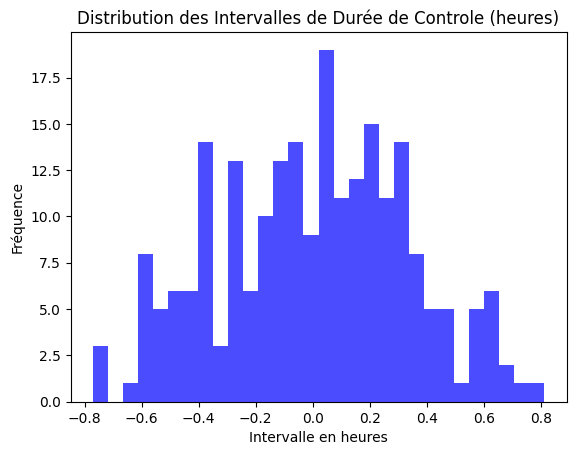

In [103]:
################# loi de durée de contrôle ##################################
# Charge les données du fichier
durations = []
with open("DonneesControle.txt", "r") as file:
    for line in file:
        data = line.strip().split()  # Sépare les valeurs par espace
        durations.append(float(data[1]))  # Récupère uniquement la durée de contrôle (deuxième valeur)
print(durations)

durations_interval = np.diff(durations)
print(durations_interval)
# Histogramme des intervalles
plt.hist(durations_interval, bins=30, alpha=0.7, color='blue')
plt.title("Distribution des Intervalles de Durée de Controle (heures)")
plt.xlabel("Intervalle en heures")
plt.ylabel("Fréquence")